# **Eine Fallstudie zur Analyse von Sensordaten und Identifikation von Zusammenhängen für frühzeitige Fehlererkennung mittels Machine Learning**

In diesem Notebook soll eine Machine Failure Prediction mittels ML-Algorithmen durchgeführt werden. Hierfür wird der folgende Kaggle-Datensatz als Grundlage verwendet: https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions/
Bei dem Datensatz handelt es sich um Daten von Fräsmachinen mit der Angabe ob und warum eine Fräsmachine versagt hat. Die Fallstudie bezieht den Datensatz auf das Unternehmen Audi AG und versucht mittel ML-Algorithmen Schlussfolgerungen zu ziehen.

#Vorbereitung der Daten
Zunächst werden wichtige Bibliotheken importiert, die Daten geladen und anschließend eine erste Begutachtung der Daten durchgeführt.

In [1]:
#Bibliotheken importieren
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split #Brauch ich zum aufteilen der Daten in Trainings- und Testsets
from sklearn.preprocessing import StandardScaler #Benötigt da Skalierung bei Logistic Regression nötig ist
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree #plot_tree für die Visualisierung
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #Für die Auswertung der ML-Algorithmen

In [3]:
#Daten laden
data = pd.read_csv("machine_failure_raw.csv")

In [4]:
#Daten begutachten
print(data.head()) #Gibt erste 5 Zeilen der Tabelle aus
print(data.info()) #Gibt Anzahl Einträge, Datentyp der Spalten aus
print(data.describe()) #Gibt an Durchschnitt, Standardabweichung, Minimum, Maximum und verschiedene Quartile

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

Der Datensatz besteht aus 10.000 Einträgen und enthält folgende Daten/besteht aus folgenden 14 Spalten:



*   **UID:** unique identifier (1 bis 10000)
*   **ProductID:** Buchstabe stellt Produktqualität dar und Seriennummer: L (niedrige PQ; 50% aller Produkte), M (mittlere PQ; 30% aller Produkte), H (hohe PQ; 20% aller Produkte)
*   **Air temperature [K]:** Lufttemperatur in Kelvin
*   **Process temperature [K]:** Betriebstemperatur in Kelvin
*   **Rotational speed [rpm]:** Drezahl in Umdrehungen pro Minute
*   **Torque [Nm]:** Drehmoment in Newtonmetern
*   **Tool wear [min]:** Werkzeugverschleiß in Minuten
*   **Machine failure:** Maschinenversagen ja/nein (0 = kein Maschinenversagen; 1 = Maschinenversagen)
*   **TWF:** tool wear failure: Ausfall durch Werkzeugverschleiß (0/1)
*   **HDF:** heat dissipation failure: Ausfall der Kühlung (0/1)
*   **PWF:** power failure: Stromausfall (0/1)
*   **OSF:** overstrain failure: Überlastungsfehler (0/1)
*   **RNF:** random failures: nicht zuordenbare Ausfälle (0/1)

#Daten bereinigen
Im nächsten Schritt werden die Daten bereinigt und vorbereitet zum weiterverarbeiten.
Hierzu gehört das Identifizieren, ob Werte fehlen und das Ersetzen fehlender Werte. Es wurde bei der Begutachtung festgestellt, dass die Daten gut strukturiert und der Datensatz vollständig befüllt ist. Deshalb konnten weitere Bereinigungen vorgenommen werden, wie das zusammenfassen der Ausfallarten in einer Spalte, sowie zur besseren Lesbarkeit die Umwandlung der Temperaturdaten von Kelvin in Celsius.  Nicht relevante Spalten wurden gedropped.

In [38]:
#Fehlende Werte

#Dieser Part nicht nötig, da der Datensatz keine Zeilen mit fehlenden Werten hat! Trotzdem vollständigkeitshalber angegeben
#Zeilen mit fehlenden Werten entfernen
#data.dropna(inplace=True)

#Fehlende Werte ersetzen
#data.fillna(0, inplace=True) #alle fehlenden Werte werden mit dem value=0 ersetzt

In [5]:
#Datenbereinigung
#Alle Ausfallarten in einer Spalte zusammenfassen
relevant = data [['TWF', 'HDF', 'PWF', 'OSF', 'RNF']] #Relevante Spalten auswählen
def find (row): #Funktion, um Spalte, aus relevanten, zu finden die 1 ist
    for column in relevant.columns:
        if row[column] == 1:
            return column
    return None

data['Machine failure type'] = relevant.apply(find, axis = 1) #Spalte mit Machine failure type hinzufügen
data['Machine failure type'].fillna("No Failure", inplace=True) #Alle Zeilen in der Spalte die kein Wert besitzt wird mit No Failure gekennzeichnet

#Daten von Kelvin in Celsius umwandeln
data['Air temperature [K]'] -= 273.15  #Lufttemperatur in Celsius umwandeln
data.rename(columns={'Air temperature [K]': 'Air temperature [C]'}, inplace=True) #Spalte umbennen in Air temperature [C]

data['Process temperature [K]'] -= 273.15  #Betriebstemperatur in Celsius umwandeln
data.rename(columns={'Process temperature [K]': 'Process temperature [C]'}, inplace=True) #Spalte umbennen in Process temperature [C]

#Product ID + UDI + 'TWF', 'HDF', 'PWF', 'OSF', 'RNF' entfernen
#neu: alle Daten heißen statt data db
db = data.drop(columns=['Product ID', 'UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

print(db.head())

  Type  Air temperature [C]  Process temperature [C]  Rotational speed [rpm]  \
0    M                24.95                    35.45                    1551   
1    L                25.05                    35.55                    1408   
2    L                24.95                    35.35                    1498   
3    L                25.05                    35.45                    1433   
4    L                25.05                    35.55                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure Machine failure type  
0         42.8                0                0           No Failure  
1         46.3                3                0           No Failure  
2         49.4                5                0           No Failure  
3         39.5                7                0           No Failure  
4         40.0                9                0           No Failure  


#Visualisierungen
In diesem Schritt wurden verschiedene Visualisierungen ausprobiert, um das Verständnis der Inhalte des Datensatzes zu vertiefen.

In [6]:
#Ausprobieren/spielen mit verschieden Visualisierungen
#Histogramm
print ("Histogramm")
px.histogram(db, y = 'Machine failure type', color = 'Machine failure type')

Histogramm


Pairplot


C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



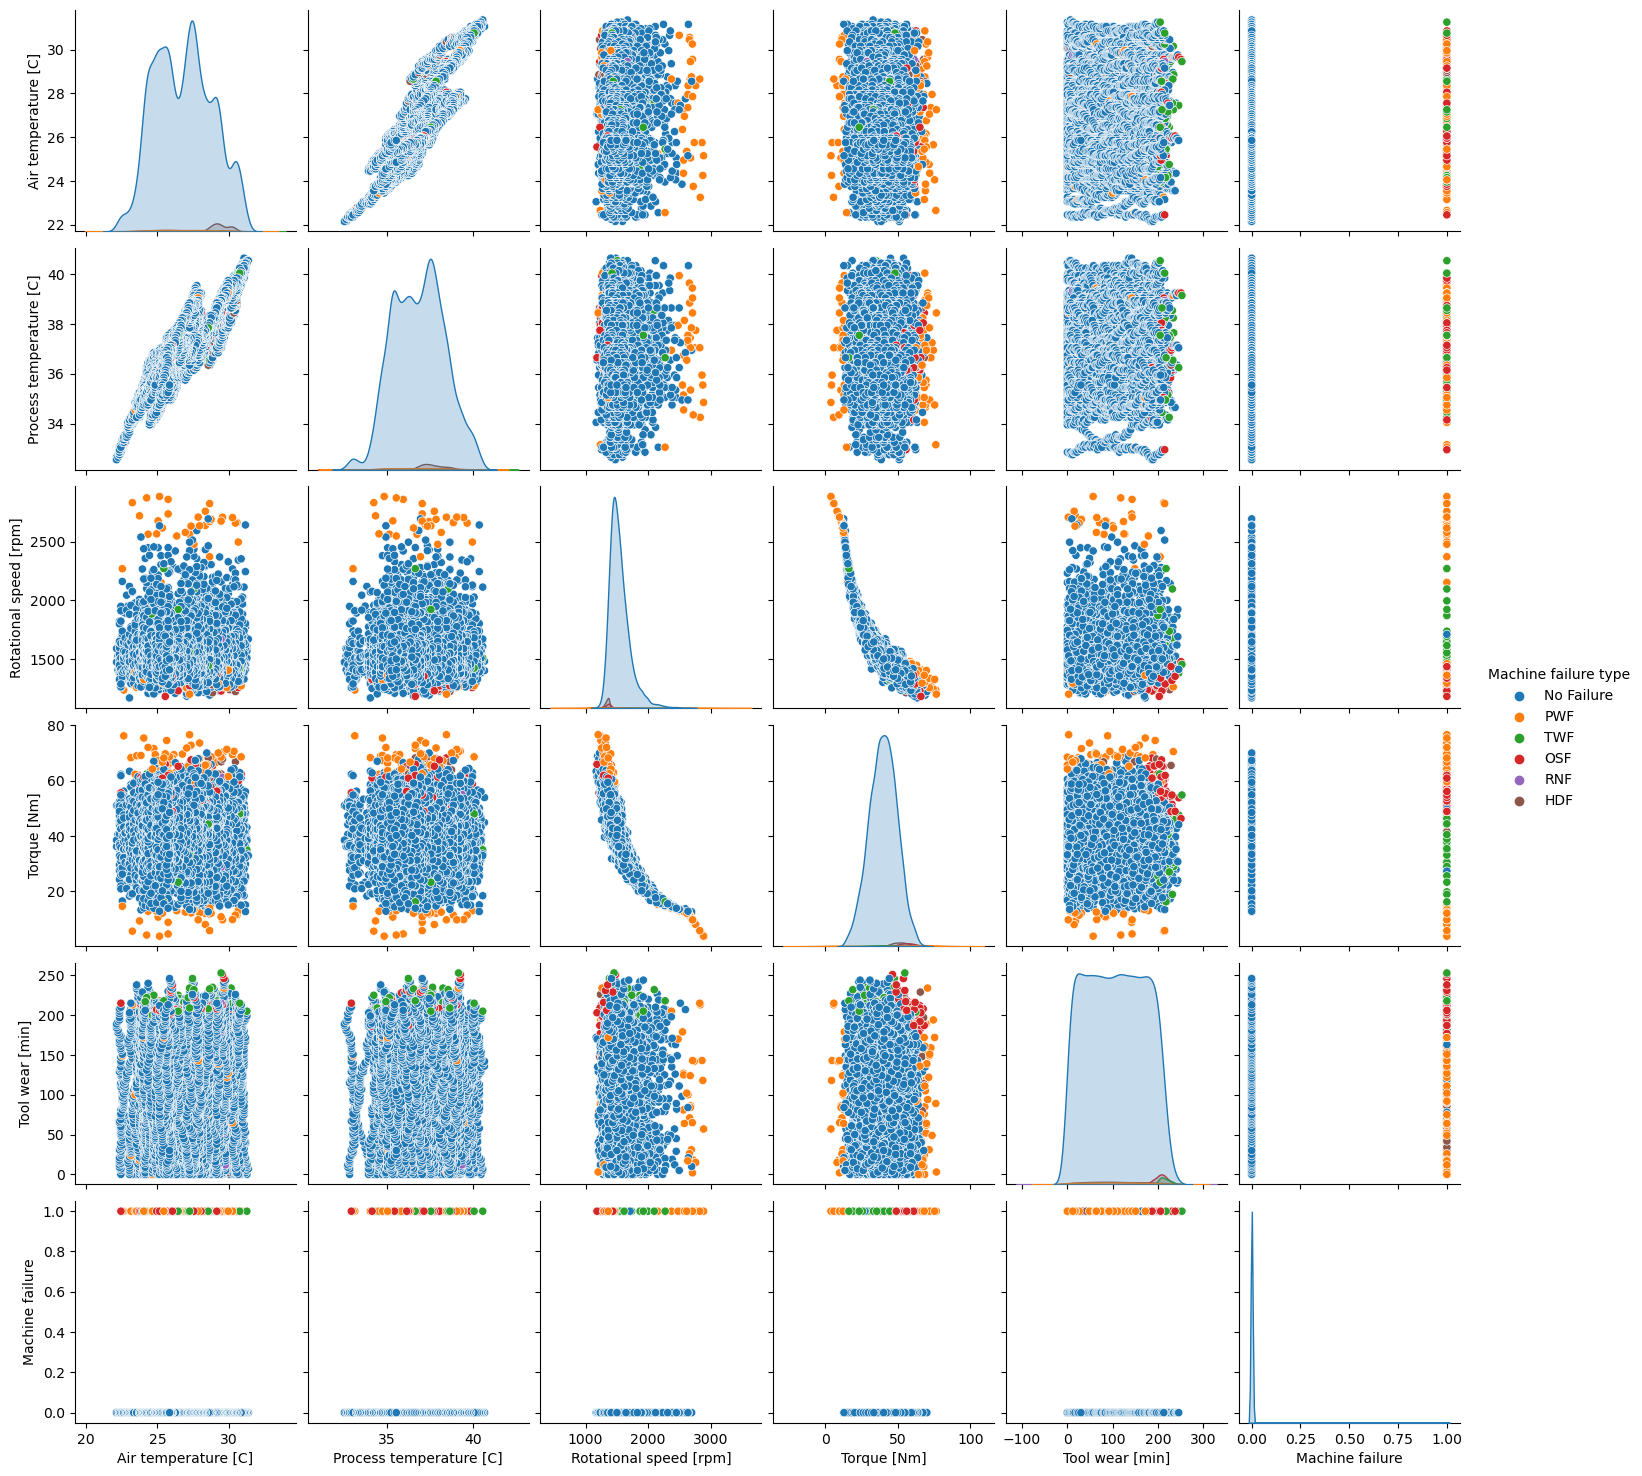

In [7]:
#Pairplot (Beziehung zwischen zwei Variablen)
print ("Pairplot")
sns.pairplot(db, hue = 'Machine failure type')

Hinweis: Hier noch überlegen, ob man Machine failure rausnimmt da kein Mehrwert

Erinnerung:

TWF: tool wear failure: Ausfall durch Werkzeugverschleiß (0/1)

HDF: heat dissipation failure: Ausfall der Kühlung (0/1)

PWF: power failure: Stromausfall (0/1)

OSF: overstrain failure: Überlastungsfehler (0/1)

RNF: random failures: nicht zuordenbare Ausfälle (0/1)

Boxplot


<Axes: xlabel='variable', ylabel='value'>

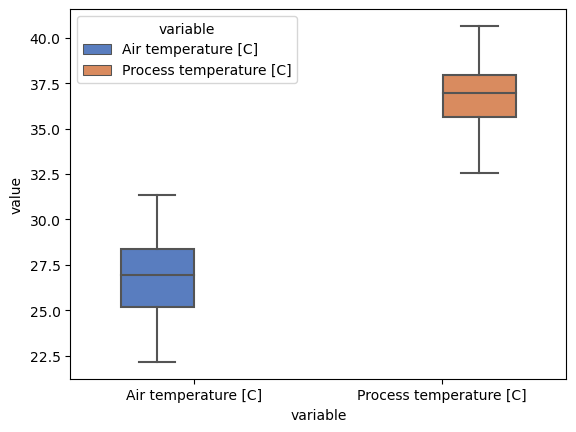

In [8]:
#Boxplots (Verteilung von numerischen Variablen)
print ('Boxplot')
#plt.figure(figsize = (10, 6))
sns.boxplot(x = 'variable', y = 'value', data = pd.melt(db[['Air temperature [C]', 'Process temperature [C]']]), hue = 'variable', width = 0.6, palette = 'muted')

Countplot


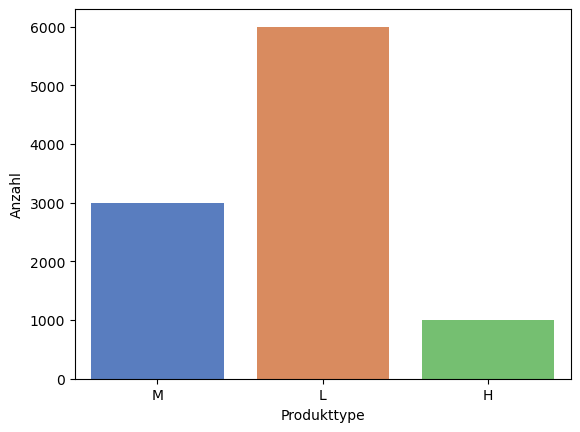

In [9]:
#Countplot Anzahl von welchem Type
print('Countplot')
sns.countplot(x = 'Type', data = db, palette = 'muted')
plt.xlabel('Produkttype')
plt.ylabel('Anzahl')
plt.show()

Heatmap


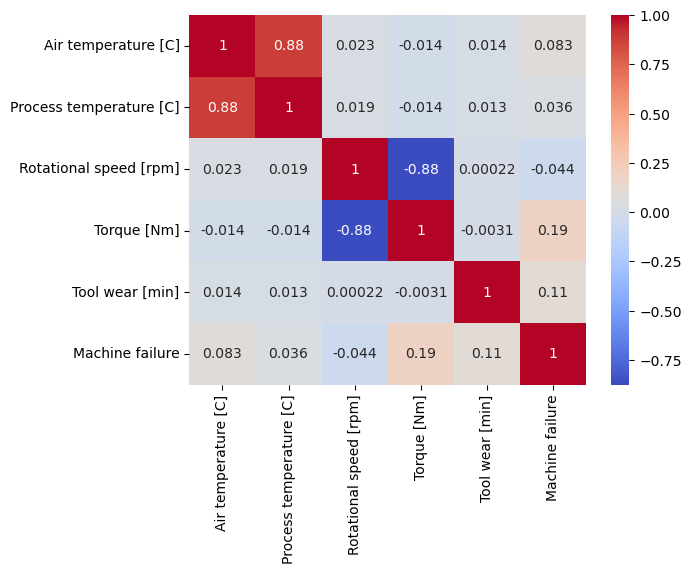

In [10]:
#Heatmap (Korrelation zwischen verschiedenen numerischen Variablen)
print ("Heatmap")
correlation_matrix = db.corr(numeric_only = True) #"FutureWarning", deshalb numeric_only=True gesetzt, da nur () evtl in der Zukunft fehler ausgibt
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

#Daten vorbereiten (Feature Engineering)
Nun werden die Daten weiter auf die ML-Modellierung vorbereitet. Hierzu werden die Daten von "Type" und "Machine failure" in jeweils einer neuen Spalte von dem Datentyp Objekt in numerische Werte (int bzw. float) geändert. Außerdem wird die Leistung (float) berechnet und ergänzt.

In [11]:
#Feature Engineering Ziel: dem Modell relevante Informationen in einer für den Algorithmus besser verständlichen Form bereitzustellen
#Type statt L, M, H Zahlen verwenden
db['Product Quality'] = db['Type'].map({'L': 1, 'M': 2, 'H': 3})

#Machine failure type in Zahlen umwandeln
db['Machine failure number'] = db['Machine failure type'].map({'No Failure': 0, 'TWF': 1, 'HDF': 2, 'PWF': 3, 'OSF': 4 , 'RNF': 5})

#Leistung berechnen
#(Drehmoment*Drezahl)/9550=Leistung in kW
db['Power'] = (db['Rotational speed [rpm]'] * db['Torque [Nm]'])/9550

print(db.head())
print(db.info())

  Type  Air temperature [C]  Process temperature [C]  Rotational speed [rpm]  \
0    M                24.95                    35.45                    1551   
1    L                25.05                    35.55                    1408   
2    L                24.95                    35.35                    1498   
3    L                25.05                    35.45                    1433   
4    L                25.05                    35.55                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure Machine failure type  \
0         42.8                0                0           No Failure   
1         46.3                3                0           No Failure   
2         49.4                5                0           No Failure   
3         39.5                7                0           No Failure   
4         40.0                9                0           No Failure   

   Product Quality  Machine failure number     Power  
0                2       

#Daten aufteilen in Trainings- und Testset


In [12]:
#Attribute/Spalten welche zum trainieren des Modells verwendet werden sollen
features = db[['Air temperature [C]', 'Process temperature [C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Product Quality', 'Power', 'Machine failure number']]
#Target Zielvariable
target = db['Machine failure type'] #Machine failure (binäres Klassifikationsproblem)

#Daten aufteilen in Trainings- und Testsets
#Daten aufteilen, um festzustellen, ob die Fräsmaschine in naher Zukunft versagen wird oder nicht
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 42) # test_size -->0.2 = 20%Test (80%Training) #random_state für Reproduzierbarkeit #random_state= 42 , Zahl kann willkürlich vergeben werden muss nur konsistent verwendet werden

print('train: ', X_train.shape, y_train.shape) #Anzahl der Zeilen und Spalten, Anzahl in der Zielvariablen (target)
print('test: ', X_test.shape, y_test.shape)

train:  (8000, 8) (8000,)
test:  (2000, 8) (2000,)


#Anwendung Machine Learning Modelle und Bewertung

Logistic Regression

Logistic Regression Model
Genauigkeit:  0.999


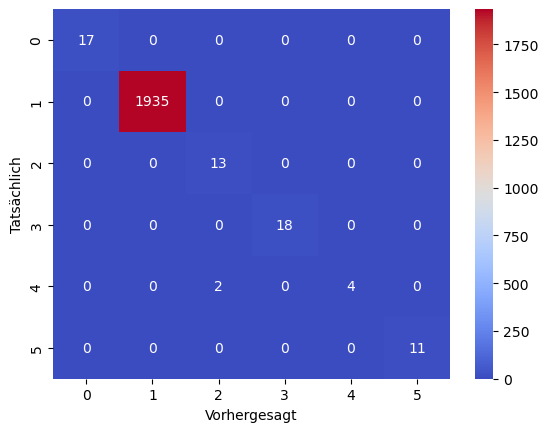

Klassifizierungsbericht:
               precision    recall  f1-score   support

         HDF       1.00      1.00      1.00        17
  No Failure       1.00      1.00      1.00      1935
         OSF       0.87      1.00      0.93        13
         PWF       1.00      1.00      1.00        18
         RNF       1.00      0.67      0.80         6
         TWF       1.00      1.00      1.00        11

    accuracy                           1.00      2000
   macro avg       0.98      0.94      0.95      2000
weighted avg       1.00      1.00      1.00      2000



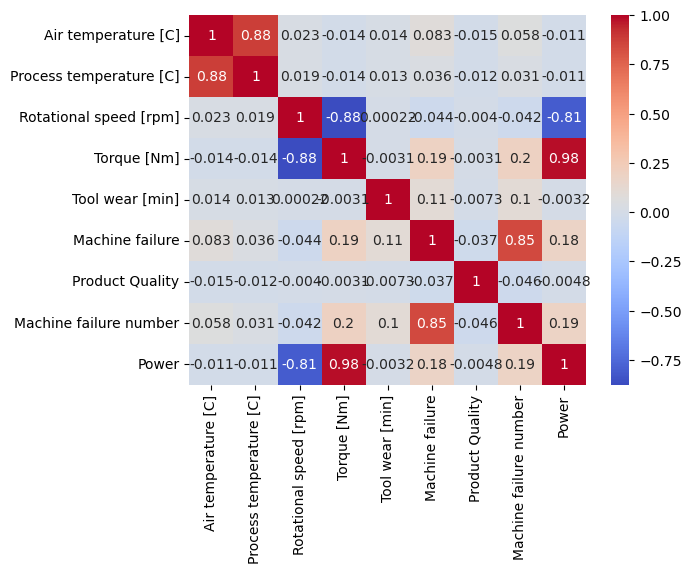

In [13]:
#Logistic Regression
#Daten skalieren, da ohne Fehlermeldung: ConvergenceWarning
scaler = StandardScaler() #Objekt erstellt, welches Skalierung der Daten durchführt. Der Mittelwert wird subtrahiert und durch Standardabweichung geteilt. Dies führt dazu, dass die skalierten Daten eine Mittelwert von 0 und eine Standardabweichung von 1 haben.
X_train_scaled = scaler.fit_transform(X_train) #StandardScaler auf X-train anwenden
X_test_scaled = scaler.transform(X_test) #Daten X_test transformieren, um Testdaten zu skalieren

#Antrainieren
logistic = LogisticRegression(random_state = 42, max_iter=1000) #Initialisieren #Iteration auf 1000 gesetzt, da "Eine geringe Anzahl von Iterationen könnte dazu führen, dass der Algorithmus nicht genügend Zeit hat, um zu konvergieren, was bedeutet, dass er nicht den optimalen Satz von Gewichtungen findet"
logistic.fit(X_train_scaled, y_train) #Trainieren #.fit berechnet Mittelwert und Standardabweichung und skaliert die Daten
ypred = logistic.predict(X_test_scaled) #Vorhersagen #y repräsentiert die Zielvariable target

#Bewerten
accuracy = accuracy_score (y_test, ypred) # Genauigkeit berechnen
matrixlr = confusion_matrix (y_test, ypred) # Confusion Matrix berechnen
report = classification_report (y_test, ypred) #Klassifizierungsbericht

#Feature Importance
#Zeigt, welche Merkmale den größten Einfluss auf die Modellvorhersagen haben
#fimportance_lr = random.feature_importances_ #Liefert Bedeutung für jeden Spaltennamen. Misst wie stark jedes Merkmal(Spalte) zur Entscheidungsfindung des Modells beiträgt
#feature_names = X_train.columns #Spaltennamen abrufen
#fimportance_lr_dataframe = pd.DataFrame({'Feature': feature_names, 'Importance': fimportance_lr}) #In DataFrame speichern
#fimportance_lr_dataframe = fimportance_lr_dataframe.sort_values(by='Importance', ascending=False) #Nach Wichtigkeit sortieren und in Variable abspeichern
#sns.barplot(x='Importance', y='Feature', data=fimportance_lr_dataframe, palette='muted') #Barplot von Feature Importance ausgeben


#Ausgabe Logistic Regression
print("Logistic Regression Model")
print("Genauigkeit: ", accuracy)
#print("Confusion Matrix:\n", matrixlr) #\n neue Zeile
sns.heatmap(matrixlr, cbar=True, cmap= "coolwarm", annot=True, fmt='.0f') #Visualisierung der Confusions Matrix in einer Heatmap
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.show()
print("Klassifizierungsbericht:\n", report)


#Heatmap Korrelationsmatrix, Korrelation zwischen verschiedenen numerischen Variablen
correlation_matrix = db.corr(numeric_only = True) #"FutureWarning", deshalb numeric_only=True gesetzt, da nur () evtl in der Zukunft fehler ausgibt
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt. show()

Schlussfolgerungen Logistic Regression:


*   Die Genauigkeit des Logistic Regression-Modells beträgt 99,95%, was auf eine sehr gute Klassifikationsleistung hinweist

*  Die Confusion Matrix zeigt, dass das Modell nur geringfügige Fehler gemacht hat, insbesondere bei der Vorhersage von "RNF" (random failures), wo es einige False Negatives gab
*   Der Klassifizierungsbericht zeigt hohe Werte für Präzision, Recall und F1-Score in den meisten Klassen, das deutet darauf hin, dass das Modell sowohl präzise als sensibel reagiert.


Decision Tree

Decision Tree Model
Genauigkeit:  0.998


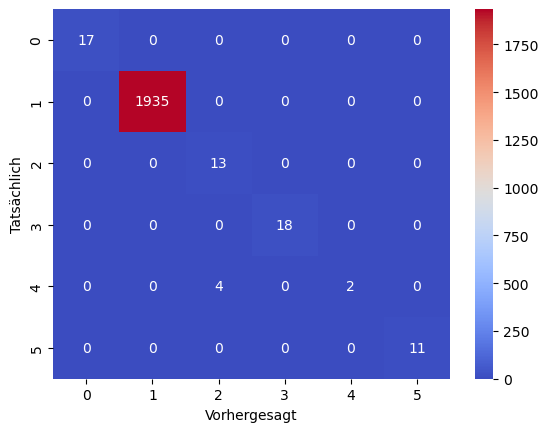

Klassifizierungsbericht:
               precision    recall  f1-score   support

         HDF       1.00      1.00      1.00        17
  No Failure       1.00      1.00      1.00      1935
         OSF       0.76      1.00      0.87        13
         PWF       1.00      1.00      1.00        18
         RNF       1.00      0.33      0.50         6
         TWF       1.00      1.00      1.00        11

    accuracy                           1.00      2000
   macro avg       0.96      0.89      0.89      2000
weighted avg       1.00      1.00      1.00      2000



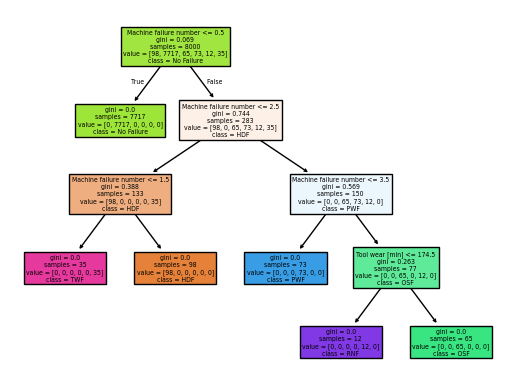

In [14]:
#Decision Tree
#Anlernen
decision = DecisionTreeClassifier(random_state=42) #Initialisieren
decision.fit(X_train, y_train) #Trainieren
ypred = decision.predict(X_test) #Vorhersagen

#Bewerten
accuracy = accuracy_score (y_test, ypred) # Genauigkeit berechnen
matrixdt = confusion_matrix (y_test, ypred) # Confusion Matrix berechnen
report = classification_report (y_test, ypred) #Klassifizierungsbericht

#Feature Importance
#Zeigt, welche Merkmale den größten Einfluss auf die Modellvorhersagen haben
#fimportance_dt = random.feature_importances_ #Liefert Bedeutung für jeden Spaltennamen. Misst wie stark jedes Merkmal(Spalte) zur Entscheidungsfindung des Modells beiträgt
#feature_names = X_train.columns #Spaltennamen abrufen
#fimportance_dt_dataframe = pd.DataFrame({'Feature': feature_names, 'Importance': fimportance_dt}) #In DataFrame speichern
#fimportance_dt_dataframe = fimportance_dt_dataframe.sort_values(by='Importance', ascending=False) #Nach Wichtigkeit sortieren und in Variable abspeichern
#sns.barplot(x='Importance', y='Feature', data=fimportance_dt_dataframe, palette='muted') #Barplot von Feature Importance ausgeben

#Ausgabe Decision Tree
print("Decision Tree Model")
print("Genauigkeit: ", accuracy)
#print("Confusion Matrix:\n", matrixdt)
sns.heatmap(matrixdt, cbar=True, cmap= "coolwarm", annot=True, fmt='.0f') #Visualisierung der Confusions Matrix in einer Heatmap
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.show()
print("Klassifizierungsbericht:\n", report)

#Plot_Tree, visualisiert Entscheidungsbaum mit Entscheidungsregeln und Ergebnisse der Klassifikation
plot_tree(decision, filled=True, feature_names=X_train.columns, class_names=decision.classes_)
plt.show()

Schlussfolgerungen Decision Tree:


*   Das Decision Tree-Modell erreicht eine Genauigkeit von 99,8%, was ebenfalls auf eine sehr gute Leistung hinweist
*  Die Confusion Matrix zeigt ähnlich wie bei der Logistic Regression nur geringfügige Fehler, vor allem bei "RNF" mit einigen False Negatives
*   Der Klassifizierungsbericht zeigt hohe Präzision, Recall und F1-Score, mit etwas niedrigeren Werten für die Klasse "RNF"
*   Der visualisierte Entscheidungsbaum zeigt die Entscheidungsregeln und die Struktur des erstellten Modells


Random Forest

Random Forest Model
Genauigkeit:  0.998


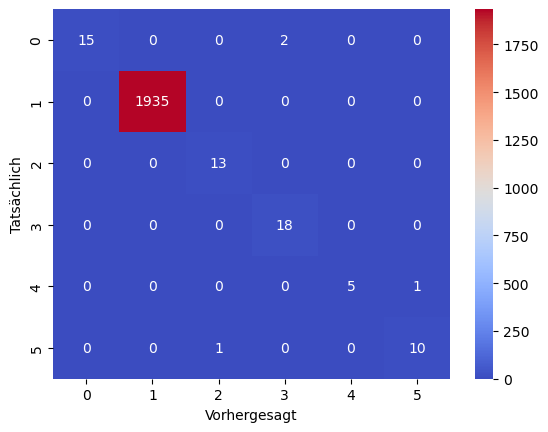

Klassifizierungsbericht:
               precision    recall  f1-score   support

         HDF       1.00      0.88      0.94        17
  No Failure       1.00      1.00      1.00      1935
         OSF       0.93      1.00      0.96        13
         PWF       0.90      1.00      0.95        18
         RNF       1.00      0.83      0.91         6
         TWF       0.91      0.91      0.91        11

    accuracy                           1.00      2000
   macro avg       0.96      0.94      0.94      2000
weighted avg       1.00      1.00      1.00      2000



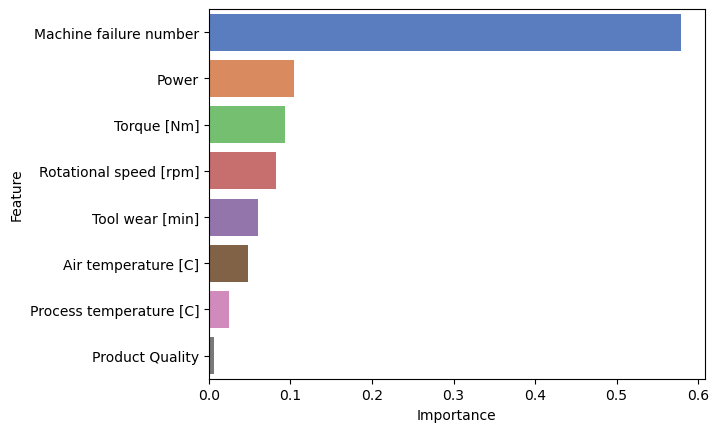

In [15]:
#Random Forest
#Anlernen
random = RandomForestClassifier(random_state=42) #Initialisieren
random.fit(X_train, y_train) #Trainieren
ypred = random.predict(X_test) #Vorhersagen

#Bewerten
accuracy = accuracy_score (y_test, ypred) # Genauigkeit berechnen
matrixrf = confusion_matrix (y_test, ypred) # Confusion Matrix berechnen
report = classification_report (y_test, ypred) #Klassifizierungsbericht

#Ausgabe Random Forest
print("Random Forest Model")
print("Genauigkeit: ", accuracy)
#print("Confusion Matrix:\n", matrixrf)
sns.heatmap(matrixrf, cbar=True, cmap= "coolwarm", annot=True, fmt='.0f') #Visualisierung der Confusions Matrix in einer Heatmap
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.show()
print("Klassifizierungsbericht:\n", report)

#Feature Importance
#Zeigt, welche Merkmale den größten Einfluss auf die Modellvorhersagen haben
fimportance = random.feature_importances_ #Liefert Bedeutung für jeden Spaltennamen. Misst wie stark jedes Merkmal(Spalte) zur Entscheidungsfindung des Modells beiträgt
feature_names = X_train.columns #Spaltennamen abrufen
fimportance_dataframe = pd.DataFrame({'Feature': feature_names, 'Importance': fimportance}) #In DataFrame speichern
fimportance_dataframe = fimportance_dataframe.sort_values(by='Importance', ascending=False) #Nach Wichtigkeit sortieren und in Variable abspeichern

sns.barplot(x='Importance', y='Feature', data=fimportance_dataframe, palette='muted') #Barplot von Feature Importance ausgeben
plt.show()

Schlussfolgerungen Random Forest:


*   Das Random Forest-Modell erreicht eine Genauigkeit von 99,8%, ähnlich wie das Decision Tree-Modell
*  Die Confusion Matrix zeigt minimale Fehler, insbesondere bei "HDF" (heat dissipation failure) mit einigen False Positives
*   Der Klassifizierungsbericht zeigt insgesamt eine sehr gute Leistung mit hohen Werten für Präzision, Recall und F1-Score
*   Der Barplot der Feature Importance zeigt, dass "Power"(Leistung) und "Torque" (Drehmoment) die wichtigsten Merkmale für die Vorhersagen des Modells sind


# Allgemeine Schlussfolgerungen


*   Alle drei Modelle (Logistic Regression, Decision Tree, Random Forest) zeigen eine hohe Genauigkeit bei der Vorhersage von Maschinenversagen.
Die Modelle unterscheiden sich in ihrer Herangehensweise, aber alle liefern gute Ergebnisse
*   Die Werte in der Random Forest Confusion-Matrix scheinen in den meisten Klassen ähnlich oder besser zu sein als die im Decision Tree.oder der Logistic Regression. Der Random Forest hat insgesamt eine höhere Anzahl von True Positives und geringere Anzahl von False Positives und False Negatives
*   Die Heatmap der Korrelationsmatrix gibt Einblicke in die Beziehungen zwischen verschiedenen numerischen Variablen
*   Weitere Verbesserungen könnten durch die Integration zusätzlicher Datenquellen und eine kontinuierliche Schulung der Modelle erreicht werden. Weitere Datenquellen könnten z.B. sein: •	Wartungshistorie •	Betriebsstunden •	Luftfeuchtigkeit • Luftdruck



